In [7]:
#import os
#os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import math
import diffusion_pde as dpde
from diffusion_pde.pdes import generate_heat
import numpy as np
import matplotlib.pyplot as plt
import torch
import h5py
from tqdm import tqdm, trange
from omegaconf import OmegaConf

from pathlib import Path    

In [8]:
root_path = Path().cwd().parent
log_rel_path = "logs/hydra/2025-11-01_17-56-58/.hydra/config.yaml" # Linear t
#log_rel_path = "logs/hydra/2025-11-01_17-56-50/.hydra/config.yaml"  # log t
config_path = root_path / log_rel_path

In [9]:
cfg = OmegaConf.load(config_path)

In [10]:
pde_name = cfg.dataset.data.pde.lower()
data_name = cfg.dataset.data.name.lower()
model_name = cfg.model.name.lower().replace(" ", "_")
save_name = f"{pde_name}_{data_name}_{model_name}"

model_path = Path().cwd().parent / "pretrained_models" / f"{save_name}.pth"
data_path = root_path / cfg.dataset.data.datapath
model_path.exists(), data_path.exists()

(True, True)

In [11]:
chs = [2, 32, 64, 128, 256]
noise_ch = 32
label_ch = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet = dpde.models.Unet(chs=chs, label_ch=label_ch, noise_ch=noise_ch)
edm = dpde.models.EDMWrapper(unet)

edm.to(device)

edm.load_state_dict(torch.load(model_path, weights_only=True))

<All keys matched successfully>

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [8]:
config = {
        "pde": pde_name,
        "dataset": data_name,
        "model": model_name,
    }
wandb_kwargs = {
    "entity": "philiphohwy-danmarks-tekniske-universitet-dtu",
    "project": "dynamical-pde-diffusion",
    "name": "test-run-validation-single-pass",
    "tags": ["testing", "unet", "edm"],
    "notes": "This is a test run to check if the validation loop works.",
    "job_type": "validation",
    "config": config,
}

cfg1_path = dpde.utils.get_repo_root() / "conf/dataset/heat_eq.yaml"
cfg1 = OmegaConf.load(cfg1_path)
validation_cfg = cfg1.validation
sampling_cfg = cfg1.sampling
save_path = dpde.utils.get_repo_root() / "logs" / "validation"

In [10]:
print(config)

{'pde': 'heat', 'dataset': 'heat_lineart', 'model': 'unet_small'}


In [11]:
print(validation_cfg.func_kwargs.steps)

50


wandb: Currently logged in as: philiphohwy (philiphohwy-danmarks-tekniske-universitet-dtu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


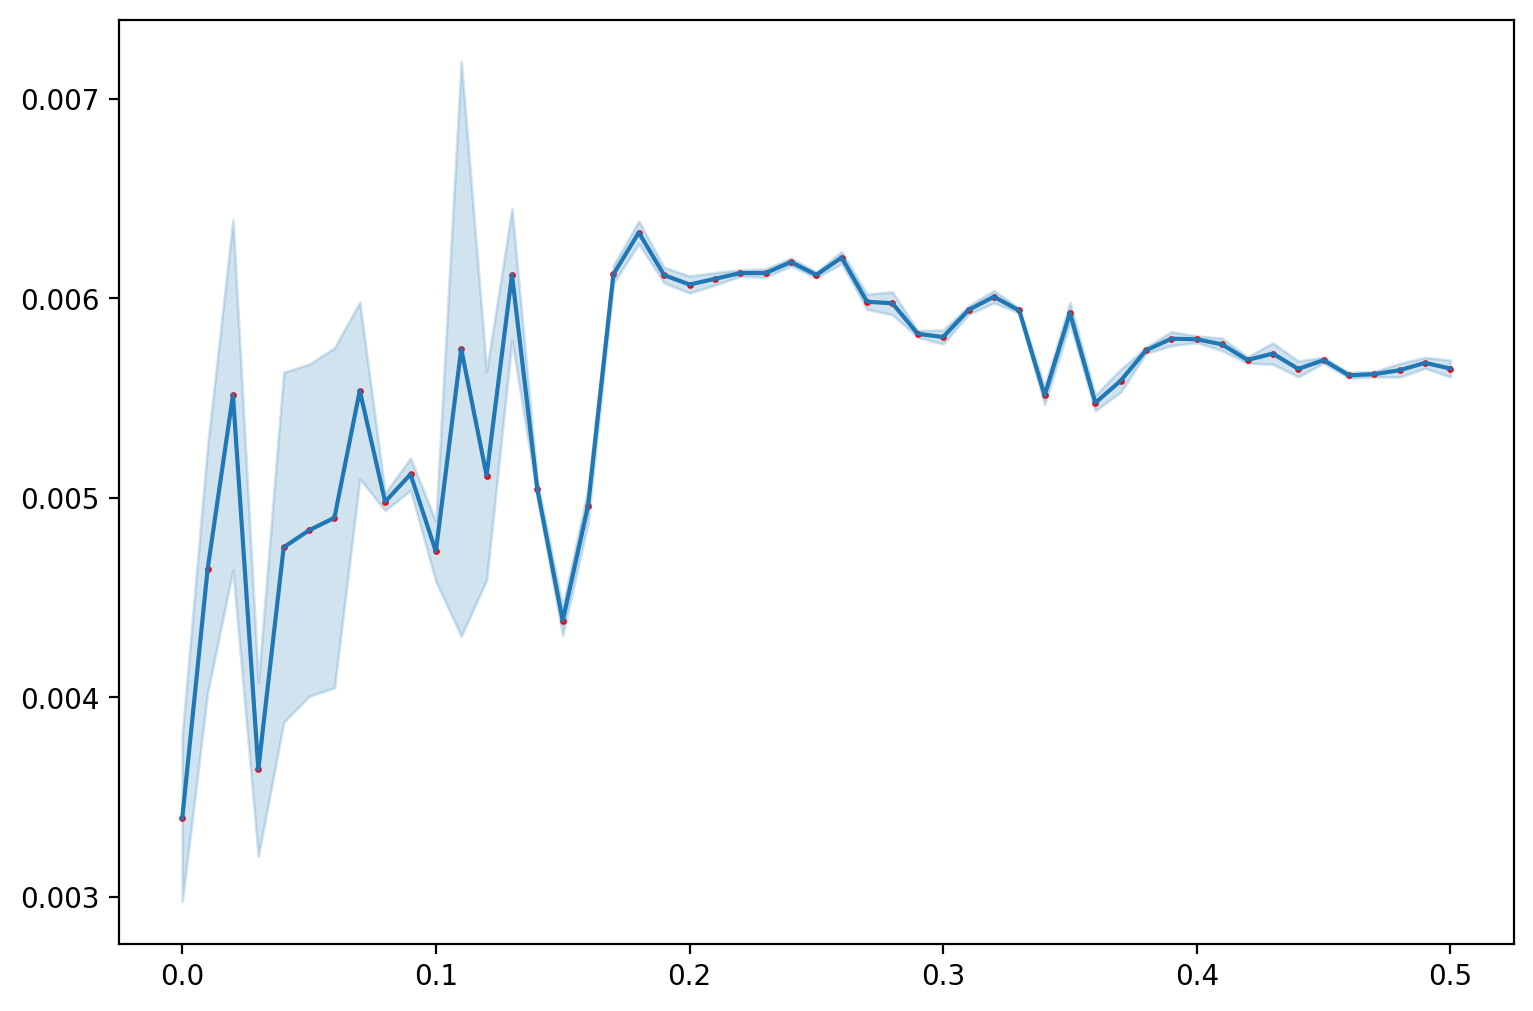

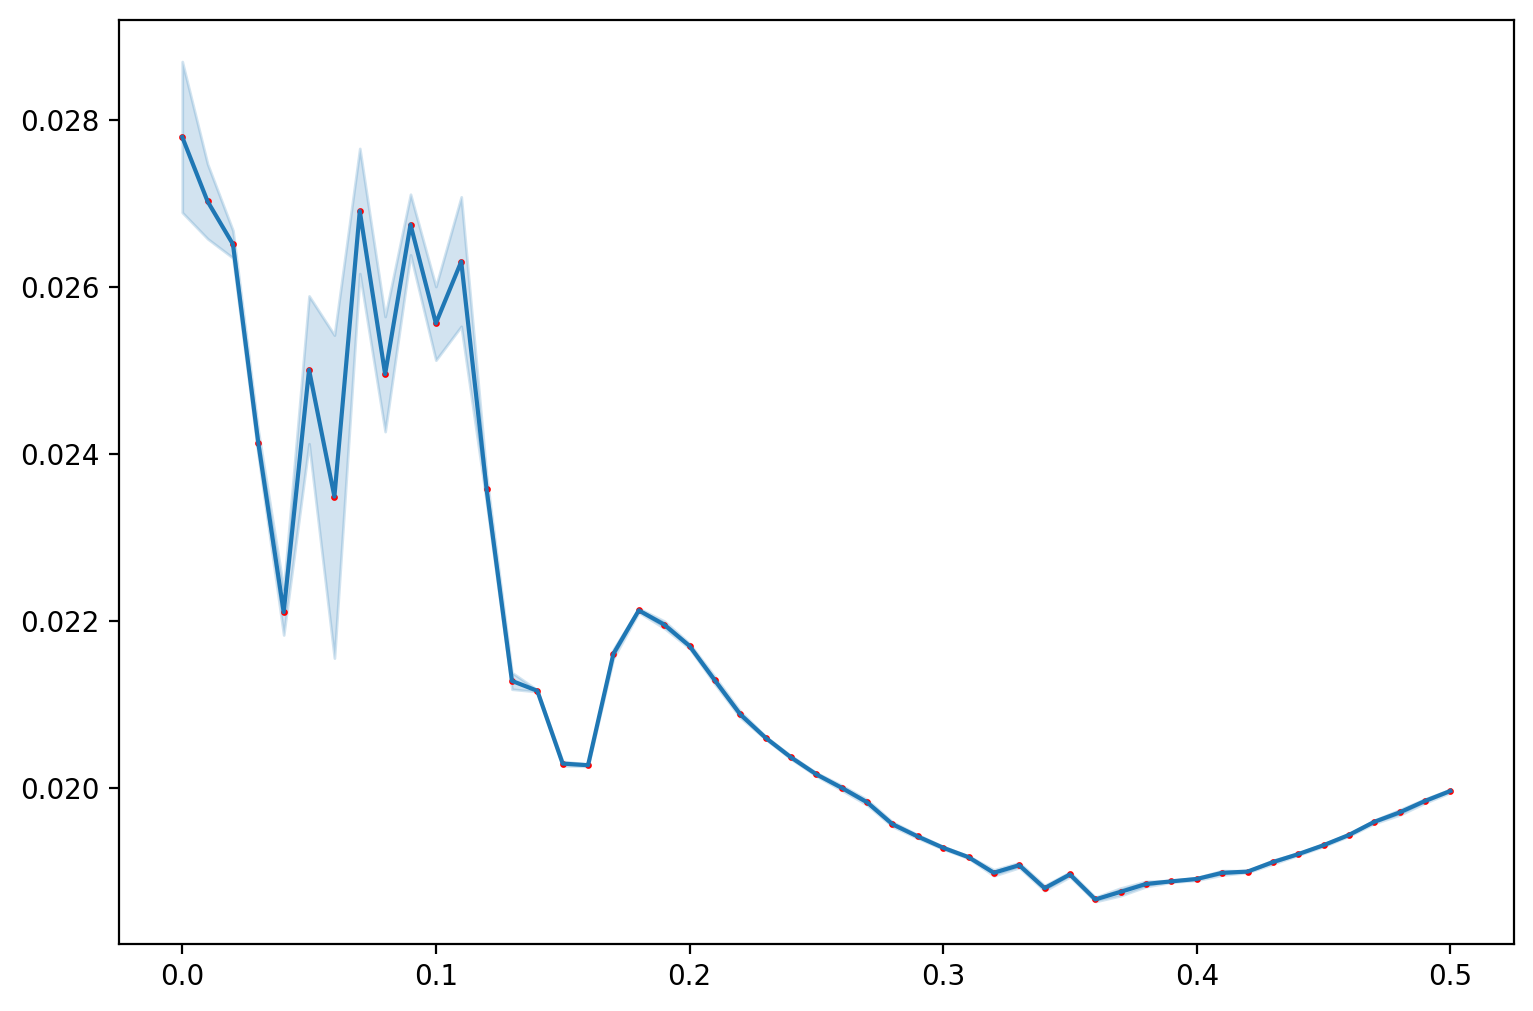

In [12]:
dpde.validation.validate_model(
    model=edm,
    validation_cfg=validation_cfg,
    sampling_cfg=sampling_cfg,
    wandb_kwargs=wandb_kwargs,
)

In [19]:
mse = np.load("/home/s204790/dynamical-pde-diffusion/logs/hydra_multirun/2025-11-03_14-11-38/4/heat_logt_unet_small_vaildation_errors.npy")
mse.shape

(50, 101, 32, 2)

In [20]:
rmse = np.sqrt(mse)
batch_mean = rmse.mean(axis=2)
rmse.shape, batch_mean.shape

((50, 101, 32, 2), (50, 101, 2))

In [21]:
mu1, std1 = batch_mean.mean(axis=0), batch_mean.std(axis=0)
mu1.min(), mu1.max()

(np.float32(39.401886), np.float32(45.287617))

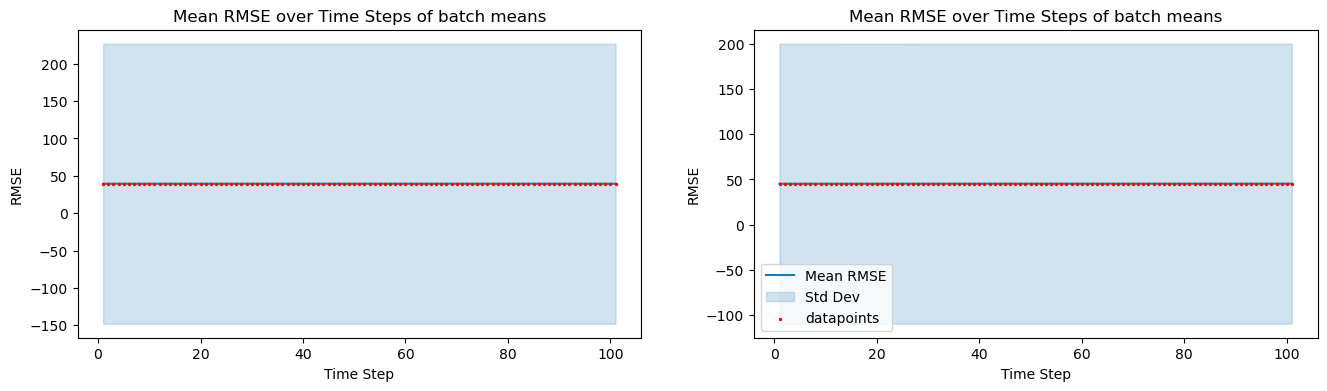

In [26]:
ch_idx = 0
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
time_steps = np.arange(1, batch_mean.shape[1] + 1)
for i, ax in enumerate(axs.flat):
    ax.plot(time_steps, mu1[:, i], label="Mean RMSE", color="C0")
    ax.fill_between(time_steps, mu1[:, i] - std1[:, i], mu1[:, i] + std1[:, i], color="C0", alpha=0.2, label="Std Dev")
    ax.scatter(time_steps, mu1[:, i], c="red", s=2, zorder=10, label="datapoints")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("RMSE")
    ax.set_title("Mean RMSE over Time Steps of batch means")
ax.legend()
plt.show()